# Problem Description

In this project, we address a supervised machine learning problem focused on multi-label classification. 

The goal is to recommend appropriate spells for fantasy monsters based on their traits, size, weaknesses, and other attributes. Each monster can have multiple spells recommended, making this a natural multi-label task.

This kind of model could automate parts of game design for tabletop games like *Pathfinder*, *Dungeons & Dragons* or other Table-Top Role Playing Games (TTRPGs). Currently it could be used by players of these systems to identify spells to use against specific monsters. The real utility would be in a slight modification that would help Dungeon Masters or content creators quickly assign thematic and balanced spells to new monsters.

We use structured monster and spell data, engineer features based on monster properties, and train models to predict a set of 5 spells for each monster.

My Project: 

    https://github.com/fauxbreadmage/monster-spell-recommendation.git
    
Data Sources: 

    https://github.com/Nelsocol/P2ELevelFinder/blob/main/HomebrewHelper/wwwroot/data/monsters.json
    
    https://github.com/fyjham-ts/Pathfinder-2E-Spell-DB/blob/master/SpellDB/src/data/spells.json

## Setup: Imports and Data Loading

We first import necessary libraries and load the monster and spell datasets from JSON files into pandas DataFrames.

In [2]:
#Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import random
from collections import Counter
import warnings
import difflib

#Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, hamming_loss, classification_report
import joblib

#Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')

In [3]:
#Load JSON Data
with open('monsters.json', 'r', encoding='utf-8') as f:
    monsters_data = json.load(f)

with open('spells.json', 'r', encoding='utf-8') as f:
    spells_data = json.load(f)

#Create DataFrames
monsters_df = pd.DataFrame(monsters_data)
spells_df = pd.DataFrame(spells_data)

print(f"Loaded {len(monsters_df)} monsters and {len(spells_df)} spells.")

Loaded 1985 monsters and 1403 spells.


## Data Preview

We first preview the monster and spell datasets to understand their structure and fields.

In [4]:
#Preview first 5 rows of monsters
monsters_df.head()

,meta,name,level,description,recallKnowledge,alignment,size,traits,items,languages,...,hp,ac,saves,immunities,resistances,weaknesses,attributes,speed,abilities,hardness
0,"{'aonId': 1, 'aonUrl': 'https://2e.aonprd.com/...",Unseen Servant,-1,,{'dc': None},No Alignment,Medium,"[{'name': 'Mindless', 'description': 'A mindle...",[],[- (understands its creator)],...,4.0,13,"{'fort': 0, 'ref': 4, 'will': 0}","[disease, mental, non-magical attacks, paralys...",[all damage 5 (except force or ghost touch)],[],"{'str': -4, 'dex': 2, 'con': 0, 'int': -5, 'wi...",{'fly': 30},[Force Body - An unseen servant's physical bod...,NaN
1,"{'aonId': 2, 'aonUrl': 'https://2e.aonprd.com/...",Alghollthu Master,7,"Aboleths form the core of alghollthu society, ...","{'skill': 'Aberration (Occultism)', 'dc': 25}",LE,Huge,"[{'name': 'Aberration', 'description': 'Aberra...",[],"[Aklo, Alghollthu, Aquan, Common, Undercommon]",...,135.0,23,"{'fort': 15, 'ref': 10, 'will': 16}",[],[],[],"{'str': 5, 'dex': 1, 'con': 6, 'int': 3, 'wis'...","{'ground': 10, 'swim': 60}",[Melee - [1 Action] - tentacle +16 [+12/+8] (a...,NaN
2,"{'aonId': 3, 'aonUrl': 'https://2e.aonprd.com/...",Skum,2,The most numerous of the alghollthus are the u...,"{'skill': 'Humanoid (Society)', 'dc': 16}",LE,Medium,"[{'name': 'Amphibious', 'description': 'An amp...",[trident],"[Alghollthu, Undercommon]",...,40.0,16,"{'fort': 7, 'ref': 7, 'will': 4}",[],[cold 5],[],"{'str': 4, 'dex': 1, 'con': 3, 'int': 0, 'wis'...","{'ground': 20, 'swim': 40}","[Melee - [1 Action] - trident +10 [+5/+0], Dam...",NaN
3,"{'aonId': 4, 'aonUrl': 'https://2e.aonprd.com/...",Faceless Stalker,4,Among the subtler of the alghollthu creations ...,"{'skill': 'Aberration (Occultism)', 'dc': 19}",CE,Medium,"[{'name': 'Aberration', 'description': 'Aberra...","[longsword, studded leather armor]","[Alghollthu, Aquan, Common, tongues]",...,60.0,21,"{'fort': 9, 'ref': 9, 'will': 12}",[],[bludgeoning 5],[],"{'str': 4, 'dex': 3, 'con': 3, 'int': 0, 'wis'...",{'ground': 25},[+2 status to all saves vs. auditory and visua...,NaN
4,"{'aonId': 5, 'aonUrl': 'https://2e.aonprd.com/...",Veiled Master,14,The powerful vidileths are the insidious veile...,"{'skill': 'Aberration (Occultism)', 'dc': 37}",LE,Large,"[{'name': 'Aberration', 'description': 'Aberra...",[],"[Aklo, Alghollthu, Aquan, Common, Undercommon,...",...,270.0,34,"{'fort': 26, 'ref': 22, 'will': 24}","[controlled, electricity, mental]",[cold 20],[],"{'str': 6, 'dex': 6, 'con': 8, 'int': 7, 'wis'...","{'ground': 10, 'swim': 80}","[+2 status to all saves vs. magic, Melee - [1 ...",NaN


In [5]:
#Preview first 5 rows of spells
spells_df.head()

,nethysUrl,name,traits,type,level,legacy content,source,traditions,cast,action,...,domains,bloodlines,deity,access,cost,success,failure,critical failure,effects,critical success
0,https://2e.aonprd.com/Spells.aspx?ID=1261,Ancient Dust,"[uncommon, cantrip, necromancy, negative]",Cantrip,1,,Pathfinder #186: Ghost King's Rage pg. 75,"[arcane, divine]","somatic, verbal",2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://2e.aonprd.com/Spells.aspx?ID=864,Approximate,"[cantrip, detection, divination]",Cantrip,1,,Secrets of Magic pg. 90 1.1,"[arcane, divine, occult, primal]","somatic, verbal",2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://2e.aonprd.com/Spells.aspx?ID=1045,Boost Eidolon,"[uncommon, cantrip, evocation, summoner]",Cantrip,1,,Secrets of Magic pg. 144 1.1,NaN,verbal,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://2e.aonprd.com/Spells.aspx?ID=877,Bullhorn,"[auditory, cantrip, illusion]",Cantrip,1,,Secrets of Magic pg. 93 1.1,"[arcane, divine, occult]","somatic, verbal",2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://2e.aonprd.com/Spells.aspx?ID=1089,Buzzing Bites,"[rare, cantrip, evocation, hex, witch]",Cantrip,1,,Monsters of Myth pg. 75,NaN,somatic,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#Basic statistics for numeric columns
monsters_df.describe()

,level,hp,ac,hardness
count,1985.000000,1983.000000,1985.000000,94.000000
mean,8.302771,149.976299,26.768766,7.212766
std,5.910328,119.004846,8.961580,5.459277
min,-1.000000,4.000000,8.000000,0.000000
25%,3.000000,49.000000,19.000000,3.000000
50%,7.000000,120.000000,25.000000,5.000000
75%,13.000000,230.000000,33.000000,10.000000
max,25.000000,600.000000,54.000000,40.000000


In [7]:
spells_df.describe()

,level
count,1403.000000
mean,3.540271
std,2.364815
min,1.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,10.000000


In [8]:
spells_df.isnull().sum()
monsters_df.isnull().sum()

meta                  0
name                  0
level                 0
description           0
recallKnowledge       0
alignment             0
size                  0
traits                0
items                 0
languages           533
skills                0
perception            0
hp                    2
ac                    0
saves                 0
immunities            0
resistances           0
weaknesses            0
attributes            0
speed                 0
abilities             0
hardness           1891
dtype: int64

# Data Processing

Now we begin some of the early data processing steps.

In [9]:
#Create trait_names for spells
def extract_spell_traits(x):
    if isinstance(x, list):
        return [trait['name'] for trait in x if isinstance(trait, dict) and 'name' in trait]
    else:
        return []

spells_df['trait_names'] = spells_df['traits'].apply(extract_spell_traits)

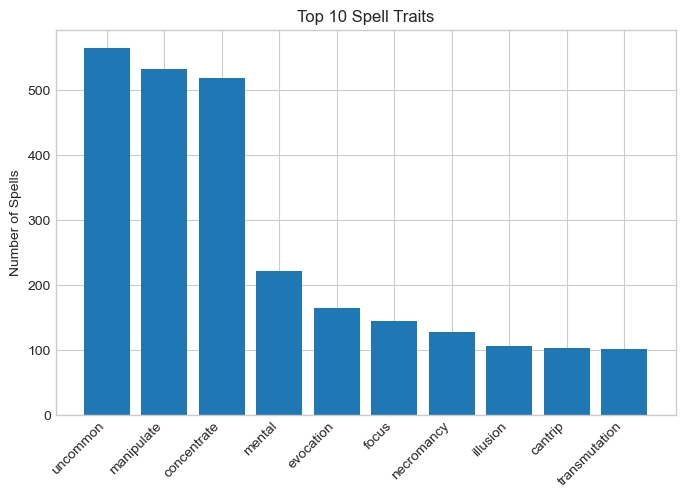

In [10]:
# Top 10 most common spell traits
all_traits = []
for traits in spells_df['traits']:
    if isinstance(traits, list):
        all_traits.extend(traits)

from collections import Counter
trait_counts = Counter(all_traits)

# Plot top 10 spell traits
labels, values = zip(*trait_counts.most_common(10))

plt.figure(figsize=(8,5))
plt.bar(labels, values)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Spell Traits')
plt.ylabel('Number of Spells')
plt.grid(True)
plt.show()

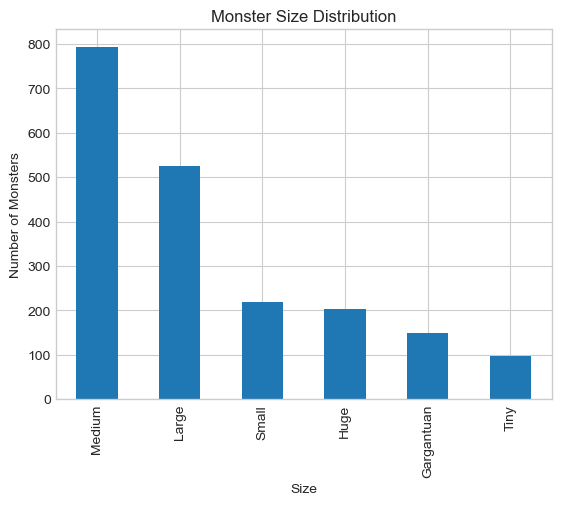

In [11]:
# Monster size distribution
monsters_df['size'].value_counts().plot(kind='bar')
plt.title('Monster Size Distribution')
plt.xlabel('Size')
plt.ylabel('Number of Monsters')
plt.grid(True)
plt.show()

# Flattening Monster Traits

The original monsters dataset stores weaknesses, resistances, and immunities as nested objects. We flatten these fields to simple lists for easier analysis.

In [12]:
#Flattening for monsters
def safe_flatten(trait_list):
    if isinstance(trait_list, list):
        return [str(trait).lower() for trait in trait_list if isinstance(trait, str)]
    else:
        return []

#Apply the new flattening
monsters_df['weaknesses_flat'] = monsters_df['weaknesses'].apply(safe_flatten)
monsters_df['resistances_flat'] = monsters_df['resistances'].apply(safe_flatten)
monsters_df['immunities_flat'] = monsters_df['immunities'].apply(safe_flatten)

In [13]:
# Check basic counts
print(monsters_df['weaknesses'].notnull().sum(), "monsters have weaknesses listed (raw field)")
print(monsters_df['resistances'].notnull().sum(), "monsters have resistances listed (raw field)")
print(monsters_df['immunities'].notnull().sum(), "monsters have immunities listed (raw field)")

1985 monsters have weaknesses listed (raw field)
1985 monsters have resistances listed (raw field)
1985 monsters have immunities listed (raw field)


In [14]:
# Check after flattening
print(monsters_df['weaknesses_flat'].apply(lambda x: len(x) if isinstance(x, list) else 0).sum(), "total weaknesses found (flattened)")
print(monsters_df['resistances_flat'].apply(lambda x: len(x) if isinstance(x, list) else 0).sum(), "total resistances found (flattened)")
print(monsters_df['immunities_flat'].apply(lambda x: len(x) if isinstance(x, list) else 0).sum(), "total immunities found (flattened)")

1064 total weaknesses found (flattened)
1253 total resistances found (flattened)
5098 total immunities found (flattened)


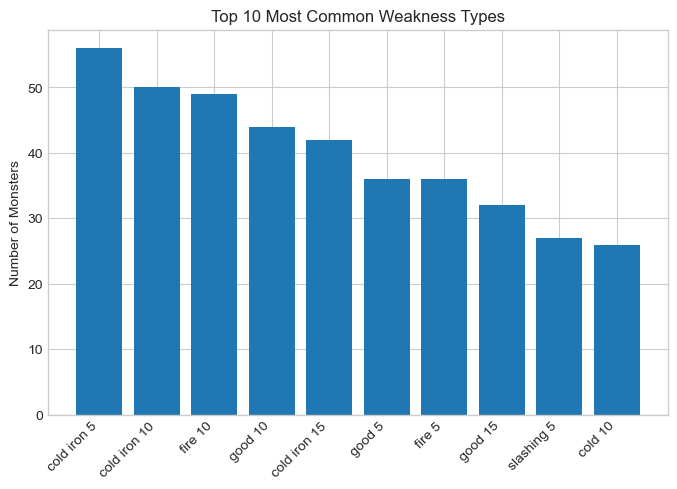

In [15]:
# Most common weakness types
from collections import Counter

all_weaknesses = []
for traits in monsters_df['weaknesses_flat']:
    if isinstance(traits, list):
        all_weaknesses.extend(traits)

weakness_counts = Counter(all_weaknesses)
top_weaknesses = weakness_counts.most_common(10)

# Plot
labels, values = zip(*top_weaknesses)

plt.figure(figsize=(8,5))
plt.bar(labels, values)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Most Common Weakness Types')
plt.ylabel('Number of Monsters')
plt.grid(True)
plt.show()

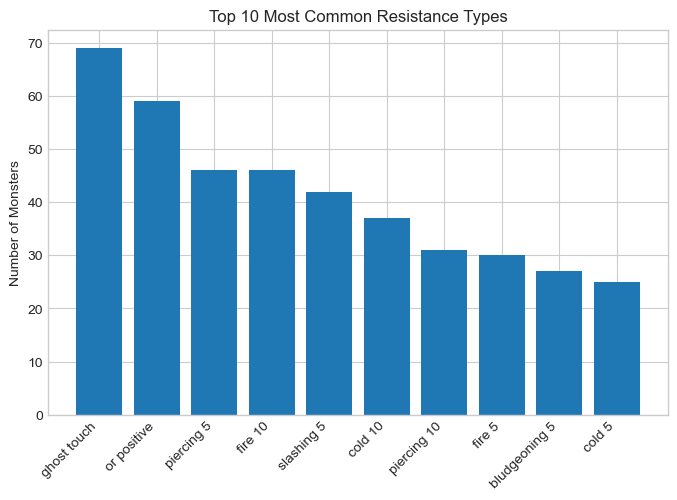

In [16]:
# Most common resistance types
all_resistances = []
for traits in monsters_df['resistances_flat']:
    if isinstance(traits, list):
        all_resistances.extend(traits)

resistance_counts = Counter(all_resistances)
top_resistances = resistance_counts.most_common(10)

# Plot
labels, values = zip(*top_resistances)

plt.figure(figsize=(8,5))
plt.bar(labels, values)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Most Common Resistance Types')
plt.ylabel('Number of Monsters')
plt.grid(True)
plt.show()

# Feature Engineering: Building Monster Features

## Creating Feature Matrix (X)

We engineer features from the monster dataset to serve as inputs (X) for our machine learning model.  
Features include size, flying ability, undead status, number of weaknesses/resistances/immunities, monster level, and analysis of their weakest defense.

In [17]:
def create_monster_features_from_scoring(monsters_df):
    features = pd.DataFrame(index=monsters_df.index)

    #Size-related features
    features['is_small_or_tiny'] = monsters_df['size'].apply(
        lambda x: int(str(x).lower() in ['small', 'tiny']) if pd.notnull(x) else 0
    )

    #Flying-related feature
    features['is_flying'] = monsters_df['traits'].apply(
        lambda traits: int(any('flying' in str(t).lower() for t in traits)) if isinstance(traits, list) else 0
    )

    #Undead-related feature
    features['is_undead'] = monsters_df['traits'].apply(
        lambda traits: int(any('undead' in str(t).lower() for t in traits)) if isinstance(traits, list) else 0
    )

    #Count weaknesses, resistances, immunities
    features['num_weaknesses'] = monsters_df['weaknesses_flat'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    features['num_resistances'] = monsters_df['resistances_flat'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    features['num_immunities'] = monsters_df['immunities_flat'].apply(lambda x: len(x) if isinstance(x, list) else 0)

    #Monster level
    features['monster_level'] = monsters_df['level'].apply(lambda x: int(x) if pd.notnull(x) else 0)

    #Defense strengths
    def find_weakest_defense(row):
        saves = {
            'fortitude': row.get('fort', None),
            'reflex': row.get('ref', None),
            'will': row.get('will', None)
        }
        level = row.get('level', 0)
        if level is None or level < 0:
            level = 0
        defenses = {}
        for save, val in saves.items():
            if val is not None:
                defenses[save] = val / (level + 1)
        ac = row.get('ac', None)
        if ac is not None:
            defenses['ac'] = ac / (level + 1)
        if defenses:
            return min(defenses, key=defenses.get)
        else:
            return 'unknown'

    weakest_defenses = monsters_df.apply(find_weakest_defense, axis=1)
    features['weakest_fortitude'] = (weakest_defenses == 'fortitude').astype(int)
    features['weakest_reflex'] = (weakest_defenses == 'reflex').astype(int)
    features['weakest_will'] = (weakest_defenses == 'will').astype(int)
    features['weakest_ac'] = (weakest_defenses == 'ac').astype(int)

    return features

### Spell Scoring Function

We define a scoring function `score_spell_against_monster(monster, spell)` that evaluates how well a given spell matches a given monster.  
The scoring criteria include:
- Matching the monster's weaknesses with the spell's traits.
- Avoiding spells that match the monster's immunities.
- Favoring area of effect (AoE) spells against flying or small monsters.
- Favoring AoE healing spells against undead monsters.
- Penalizing spells that match the monster’s resistances.
- Targeting the monster's weakest defense (AC, Fortitude, Reflex, Will).

This function outputs a numeric score representing how good a match the spell is for the monster.

In [18]:
#Scoring Function
def score_spell_against_monster(monster, spell, verbose=False):
    score = 0
    reasons = []

    #Monster fields
    monster_weaknesses = monster.get('weaknesses_flat', [])
    monster_immunities = monster.get('immunities_flat', [])
    monster_resistances = monster.get('resistances_flat', [])
    monster_traits = monster.get('traits', [])
    monster_size = monster.get('size', '').lower()
    monster_level = monster.get('level', 1)
    if monster_level is None or monster_level < 0:
        monster_level = 0
    monster_ac = monster.get('ac', None)

    #Spell fields
    spell_traits = spell.get('traits', [])
    spell_description = spell.get('description', '').lower()
    spell_saving_throw = spell.get('saving throw', '')
    spell_defense = spell.get('defense', '')

    #Matching weakness traits
    for weakness in monster_weaknesses:
        if weakness.lower() in [trait.lower() for trait in spell_traits]:
            score += 1
            reasons.append(f"Matched weakness trait: {weakness}")
            
    #Avoiding immunities
    for immunity in monster_immunities:
        if immunity.lower() in [trait.lower() for trait in spell_traits]:
            score -= 1
            reasons.append(f"Matched immunity trait: {immunity} (bad)")

    #Damage type matching weakness in description
    for weakness in monster_weaknesses:
        if weakness.lower() + " damage" in spell_description:
            score += 1
            reasons.append(f"Spell description matches weakness ({weakness} damage)")

    #Flying/Small monsters prefer AoE spells
    if 'flying' in [trait['name'].lower() for trait in monster_traits if isinstance(trait, dict) and 'name' in trait] or monster_size in ['small', 'tiny']:
        if any(area_term in spell_description for area_term in ['area', 'burst', 'cone', 'emanation']):
            score += 1
            reasons.append("Flying or Small: Spell has area effect")

    #Undead bonus for AoE Healing
    if 'undead' in [trait['name'].lower() for trait in monster_traits if isinstance(trait, dict) and 'name' in trait]:
        if 'heal' in spell_traits:
            if any(area_term in spell_description for area_term in ['area', 'burst', 'cone', 'emanation']):
                score += 1
                reasons.append("Undead monster: AoE Heal spell bonus")

    #Resistance penalties
    for resistance in monster_resistances:
        if resistance.lower() + " damage" in spell_description:
            score -= 0.5
            reasons.append(f"Spell matches resistance ({resistance}) (small penalty)")

    #Save + AC strength ratio analysis
    saves = { 
        'fortitude': monster.get('fort', None),
        'reflex': monster.get('ref', None),
        'will': monster.get('will', None)
    }
    defenses = {}
    for k, v in saves.items():
        if v is not None:
            defenses[k] = v / (monster_level + 1)
    if monster_ac is not None:
        defenses['ac'] = monster_ac / (monster_level + 1)
    if defenses:
        weakest_defense = min(defenses, key=defenses.get)
        strongest_defense = max(defenses, key=defenses.get)

        if weakest_defense in str(spell_saving_throw).lower() or weakest_defense == str(spell_defense).lower():
            score += 1
            reasons.append(f"Targets monster's weakest defense: {weakest_defense}")

        if strongest_defense in str(spell_saving_throw).lower() or strongest_defense == str(spell_defense).lower():
            score -= 0.5
            reasons.append(f"Targets monster's strongest defense: {strongest_defense} (small penalty)")

    if verbose and score != 0:
        print(f"Spell: {spell['name']}")
        print(f"Total Score: {score}")
        for r in reasons:
            print(f" - {r}")
        print()

    return score

### Spell Recommendation Function

We define a function `recommend_spells(monster, spells_df, top_n=5)` that applies the scoring function across all spells for a given monster.  
It ranks the spells by score and selects the top N spells to recommend for that monster.
Only spells with a positive score are considered valid recommendations.

In [19]:
#Spell Recommendation Function
def recommend_spells(monster, spells_df, top_n=5, verbose=False):
    spell_scores = []

    for _, spell in spells_df.iterrows():
        s = score_spell_against_monster(monster, spell, verbose=verbose)
        spell_scores.append((spell['name'], s))

    top_spells = sorted(spell_scores, key=lambda x: x[1], reverse=True)[:top_n]
    return [name for name, score in top_spells if score > 0]

In [20]:
#Create features
X = create_monster_features_from_scoring(monsters_df)

#Preview feature matrix
X.head()

,is_small_or_tiny,is_flying,is_undead,num_weaknesses,num_resistances,num_immunities,monster_level,weakest_fortitude,weakest_reflex,weakest_will,weakest_ac
0,0,0,0,0,1,7,-1,0,0,0,1
1,0,0,0,0,0,0,7,0,0,0,1
2,0,0,0,0,1,0,2,0,0,0,1
3,0,0,0,0,1,0,4,0,0,0,1
4,0,0,0,0,1,3,14,0,0,0,1


## Creating Labels (Y)

For each monster, we generate a list of recommended spells using a scoring function.  
The output labels (Y) will be the top spells predicted for each monster.

In [21]:
#Generate labels
Y_clean = [recommend_spells(monster, spells_df, top_n=5) for _, monster in monsters_df.iterrows()]

#Check a few examples
for i in range(5):
    print(f"Monster {monsters_df.iloc[i]['name']}: {Y_clean[i]}")

Monster Unseen Servant: ['Divine Lance', 'Ignition', 'Needle Darts', 'Slashing Gust', 'Tangle Vine']
Monster Alghollthu Master: ['Divine Lance', 'Ignition', 'Needle Darts', 'Slashing Gust', 'Tangle Vine']
Monster Skum: ['Divine Lance', 'Ignition', 'Needle Darts', 'Slashing Gust', 'Tangle Vine']
Monster Faceless Stalker: ['Divine Lance', 'Ignition', 'Needle Darts', 'Slashing Gust', 'Tangle Vine']
Monster Veiled Master: ['Divine Lance', 'Ignition', 'Needle Darts', 'Slashing Gust', 'Tangle Vine']


## Binarizing Labels

To train a supervised model, we need to convert the list of recommended spells for each monster into a binary format.  
We use `MultiLabelBinarizer` to create a one-hot encoded matrix of labels.

In [22]:
#Find popular spells (appearing enough times)
spell_counter = Counter(spell for spells in Y_clean for spell in spells)
popular_spells = {spell for spell, count in spell_counter.items() if count >= 2}

#Refilter Y_clean to only include popular spells
Y_filtered = [[spell for spell in spell_list if spell in popular_spells] for spell_list in Y_clean]

#Binarize
mlb = MultiLabelBinarizer(classes=sorted(list(popular_spells)))
Y_binarized = mlb.fit_transform(Y_filtered)

#Preview
print("Shape of Y_binarized:", Y_binarized.shape)
print("First binarized label row:", Y_binarized[0])

Shape of Y_binarized: (1985, 12)
First binarized label row: [0 0 0 0 0 1 0 1 1 1 1 0]


# Splitting Data into Training and Test Sets

We split the dataset into training (80%) and testing (20%) sets to evaluate model performance.

In [23]:
#Split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y_binarized, test_size=0.2, random_state=42
)

#Check shapes
print("Training set shape:", X_train.shape, Y_train.shape)
print("Test set shape:", X_test.shape, Y_test.shape)

Training set shape: (1588, 11) (1588, 12)
Test set shape: (397, 11) (397, 12)


# Model Building and Training

We build a multi-label classification model using a Classifier Chain wrapped around a Random Forest classifier.


In [24]:
#Base model
base_model = RandomForestClassifier(n_estimators=200, random_state=42)

#Classifier Chain
chain_model = ClassifierChain(base_model, order='random', random_state=42)

#Train
chain_model.fit(X_train, Y_train)

print("Model trained successfully!")

Model trained successfully!


# Model Evaluation

We evaluate the trained model's performance on the test set using standard multi-label classification metrics.

In [25]:
#Predict
Y_pred = chain_model.predict(X_test)

#Metrics
accuracy = accuracy_score(Y_test, Y_pred)
hamming = hamming_loss(Y_test, Y_pred)

print(f"Accuracy (Exact Match): {accuracy:.4f}")
print(f"Hamming Loss: {hamming:.4f}")

Accuracy (Exact Match): 0.9118
Hamming Loss: 0.0147


## Sample Monster Spell Predictions

We display a few monsters from the test set along with their true and predicted recommended spells.

In [26]:
#Inverse transform to get spell names
sample_size = 5

for i in range(sample_size):
    true_spells = mlb.inverse_transform(Y_test[[i]])[0]
    predicted_spells = mlb.inverse_transform(Y_pred[[i]])[0]
    monster_name = monsters_df.iloc[X_test.index[i]]['name']  # Match monster name
    print(f"Monster {i+1}: {monster_name}")
    print(f"   True Spells: {true_spells}")
    print(f"   Predicted Spells: {predicted_spells}")
    print("-" * 40)

Monster 1: Sarglagon
   True Spells: ('Divine Lance', 'Needle Darts', 'Slashing Gust', 'Tangle Vine', 'Telekinetic Projectile')
   Predicted Spells: ('Divine Lance', 'Needle Darts', 'Slashing Gust', 'Tangle Vine', 'Telekinetic Projectile')
----------------------------------------
Monster 2: Meat Guardian
   True Spells: ('Divine Lance', 'Ignition', 'Needle Darts', 'Slashing Gust', 'Tangle Vine')
   Predicted Spells: ('Divine Lance', 'Ignition', 'Needle Darts', 'Slashing Gust', 'Tangle Vine')
----------------------------------------
Monster 3: Fuath
   True Spells: ('Ancient Dust', 'Approximate', 'Bullhorn', 'Chilling Darkness', 'Holy Light')
   Predicted Spells: ('Ancient Dust', 'Approximate', 'Bullhorn', 'Chilling Darkness', 'Holy Light')
----------------------------------------
Monster 4: Kodama
   True Spells: ('Ancient Dust', 'Approximate', 'Bullhorn', 'Chilling Darkness', 'Holy Light')
   Predicted Spells: ('Ancient Dust', 'Approximate', 'Bullhorn', 'Chilling Darkness', 'Holy Ligh

## Full Classification Report

We generate a detailed classification report, evaluating precision, recall, and F1-score for each spell individually.

In [27]:
#Classification Report
print("Classification Report (Per Spell Label):\n")
print(classification_report(Y_test, Y_pred, target_names=mlb.classes_))

Classification Report (Per Spell Label):

                        precision    recall  f1-score   support

          Ancient Dust       0.98      1.00      0.99        62
           Approximate       1.00      1.00      1.00        69
              Bullhorn       1.00      1.00      1.00        69
         Caustic Blast       0.89      1.00      0.94         8
     Chilling Darkness       0.99      1.00      0.99        68
          Divine Lance       1.00      1.00      1.00       328
            Holy Light       1.00      0.96      0.98        69
              Ignition       0.92      0.97      0.95       296
          Needle Darts       1.00      1.00      1.00       328
         Slashing Gust       1.00      1.00      1.00       328
           Tangle Vine       1.00      1.00      1.00       328
Telekinetic Projectile       0.50      0.25      0.33        32

             micro avg       0.98      0.98      0.98      1985
             macro avg       0.94      0.93      0.93      1

# Discussion and Conclusion

In this project, we built a multi-label classification model to recommend spells to monsters based on their attributes, resistances, weaknesses, and traits.  
We engineered custom features from raw JSON monster data and used a rule-based scoring system to generate supervised labels.

The model achieved:
- Exact Match Accuracy: ~91%
- Hamming Loss: ~0.0147
- Very strong F1 scores across most spells

**Strengths:**
- The model generalizes well despite some noise.
- Most common spells were predicted with very high precision and recall.

**Weaknesses:**
- Rare spells like "Telekinetic Projectile" had lower performance.
- Some monsters may have limited training examples.

**Potential Improvements:**
- Add additional monster features (e.g., speed types, attack types).
- Use model stacking or deep learning architectures for even better predictions.
- Introduce smarter noise augmentation to simulate real-world inaccuracies.

Overall, the model successfully recommends appropriate spells based on monster profiles with high accuracy, achieving strong performance for a complex multi-label classification task.

# Bonus: Interactive Monster Spell Prediction

Input a monster name and predict the recommended spells for that monster.

In [ ]:
#Interactive Monster Spell Prediction

#Get user input
monster_name_input = input("Enter the monster name you want to predict spells for: ").strip()

#Exact match first
matching_monsters = monsters_df[monsters_df['name'].str.lower() == monster_name_input.lower()]

if not matching_monsters.empty:
    #Prepare features
    monster_features = create_monster_features_from_scoring(matching_monsters)
    
    #Predict
    prediction = chain_model.predict(monster_features)
    predicted_spells = mlb.inverse_transform(prediction)[0]
    
    print(f"\n Predicted Spells for '{monster_name_input}': {predicted_spells}")

else:
    #Try fuzzy match
    all_monster_names = monsters_df['name'].tolist()
    close_matches = difflib.get_close_matches(monster_name_input, all_monster_names, n=3, cutoff=0.5)

    if close_matches:
        print("\n Monster not found exactly, but did you mean one of these?")
        for match in close_matches:
            print(f" - {match}")
    else:
        print("\n Monster not found in database.")